In [56]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
from seaborn import violinplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from numpy.random import random_sample
from scipy.stats import linregress
import subprocess
from time import perf_counter
from tqdm import tqdm
import pickle

def pysurf96(hr,vp,vs,rho,model_file='model-from-python.d'):

    lines = ['MODEL',
             'TEST MODEL',
            'ISOTROPIC',
            'KGS',
            'FLAT EARTH',
            '1-D',
            'CONSTANT VELOCITY',
            'LINE08',
            'LINE09',
            'LINE10',
            'LINE11',
            'HR    VP    VS    RHO   QP  QS  ETAP ETAS FREFP FREFS']
    for h,p,s,r in zip(hr,vp,vs,rho):
#         lines.append(f'{h:.3f} {p:.3f} {s:.3f} {r:.3f}  0.0 0.0 0.0  0.0  1.0   1.0')
        lines.append(f'{h} {p} {s} {r}  0.0 0.0 0.0  0.0  1.0   1.0')
    
    with open(model_file, 'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')
    
    result = subprocess.run(['./model.sh'], stdout=subprocess.PIPE)
    
    data=pd.read_fwf('SDISPR.TXT',header=1,colspecs=[(22,34),(38,52)])
    f = data['FREQ']
    k = data['FREQ']/data['PHASE VEL']/1e3
    return f,k

def plt_dispersion(f,k,fobs,kobs,z,vs):

    fig,ax=plt.subplots(1,2,figsize=(16,9))
    fig.patch.set_facecolor('w')
    plt.subplot(121)
    plt.step(vs,z,label='Vs (km/s)')
    # plt.step(p,z,label='Vp (km/s)')
    # plt.step(rho,z,'--',label='Density (kg/m**3)')
    plt.ylim([max(z),0])
    plt.grid()
    # plt.legend(fontsize=18)
    plt.ylabel('Depth (m)',fontsize=22)
    plt.xlabel('Shear Wave Speed (m/s)',fontsize=22)
    plt.text(0.1,50,'water',fontsize=18)
    plt.text(100,120,'fluidized \nsediments',fontsize=18)
    plt.text(400,150,'   compact \n sediments',fontsize=18)

    plt.xlim([0, 650])

    plt.subplot(122)
    plt.plot(k,f,'-o',label='Model',markersize=12)
    plt.plot( kobs , fobs, 'o' , label='Observation',markersize=10)
    plt.ylabel('Frequency (Hz)',fontsize=22)
    plt.xlabel(r'Ordinary Wavenumber, $1/\lambda$ (1/m)',fontsize=22)

    
    fit = linregress(kobs,fobs)
    plt.plot(kobs, fit.slope*kobs + fit.intercept,'--',label=f'Constant vg ({fit.slope:.0f} m/s)')

    plt.legend(fontsize=18)
    plt.grid()
    plt.show()

In [2]:
def exp_vs(z,z0,exp,coeff):
    return (coeff*(z - z0))**exp
z_water = 90

In [3]:
kobs = np.array([0.0343, 0.0305, 0.0246, 0.020, 0.0150, 0.0113, 0.0059, 0.0029, 0.00042])
fobs = np.array([1.335, 1.265, 1.125, 1.01, 0.88, 0.77, 0.585, 0.46, 0.378])
cobs = fobs/kobs

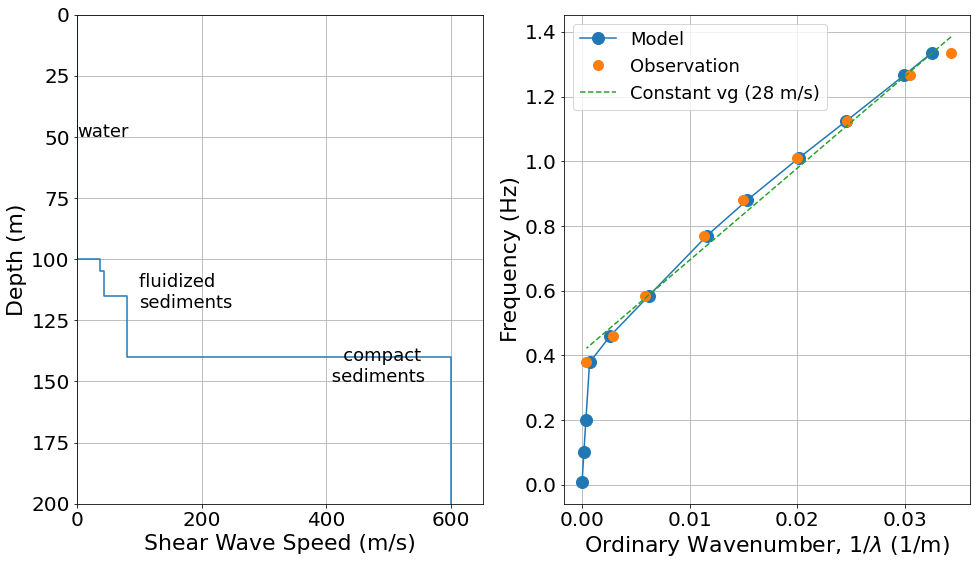

In [182]:
# Four layer model
h =  [0.100, 0.005, 0.010, 0.025, 0.0]
vs = [0, 0.038, 0.043, 0.080, 0.600]
vp = [1.5,1.6,1.6,1.6,1.6]
rho= [1,1.5,1.5,1.5,1.5]

f,k = pysurf96(h,vp,vs,rho)

plt_dispersion(f,k,fobs,kobs,
               np.hstack([0,np.cumsum(h)*1e3,200]),
               1000*np.hstack([vs,vs[-1],vs[-1]]))

# MCMC/MS on velocity structure

In [89]:
def wrap_four_layer(p,h,k_obs):
    this_vs = [0,p[0],p[1],p[2],p[3]]
    f,k = pysurf96(h,vp,this_vs,rho)
    misfit = np.abs(k[3:]-k_obs).sum()

    return misfit

In [78]:
t0 = perf_counter()

step_size = 2.5e-4 # 0.25 m/s
# k_sensitivity = 0.000418 * len(kobs)
k_sensitivity = 7.5e-5
x0 = [0.038,0.043,0.080,0.60]
h0 = [0.1,0.005,0.010,0.020,0.0]
m0 = wrap_four_layer(x0,h0,kobs)
N = 100000

x_list = []
for i in tqdm(range(N)):
    x = x0 + step_size*(2*random_sample(len(x0))-1)
    m = wrap_four_layer(x,h0,kobs)
    L =  np.exp(-(m-m0)**2 / k_sensitivity**2)
    thr = random_sample()
    if L >= thr:
        x_list.append(x)
        x0 = x
        m0 = m
x_list = np.array(x_list) * 1e3
print(f'Runtime was {perf_counter()-t0}')

100%|█████████████████████████████████| 100000/100000 [1:25:10<00:00, 19.57it/s]

Runtime was 5110.482976678992


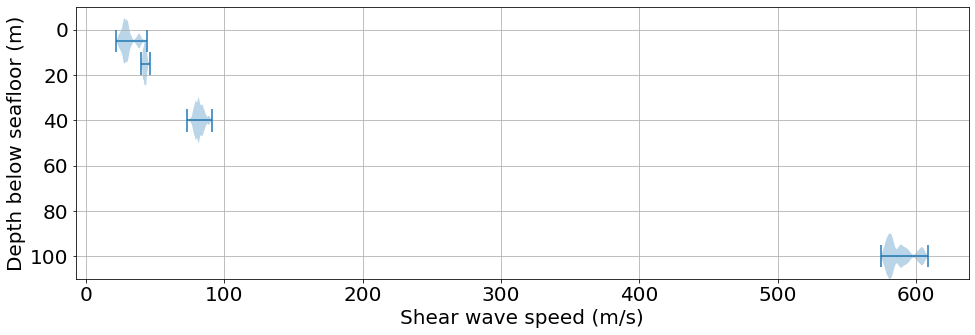

In [79]:
fig,ax=plt.subplots(figsize=(16,5))
fig.patch.set_facecolor('w')
ax.violinplot(x_list,positions=[5,15,40,100],widths=20,vert=False)
plt.ylim([110,-10])
plt.xlabel('Shear wave speed (m/s)',fontsize=20)
plt.ylabel('Depth below seafloor (m)',fontsize=20)
plt.grid()

In [80]:
burnin_threshold = 0.33
print(f'Total accepted steps: {len(x_list)}')
print(f'Burn-in length: {round(len(x_list)*burnin_threshold)}')
x_list_subset=x_list[round(len(x_list)*burnin_threshold):-1,:]

Total accepted steps: 14923
Burn-in length: 4925


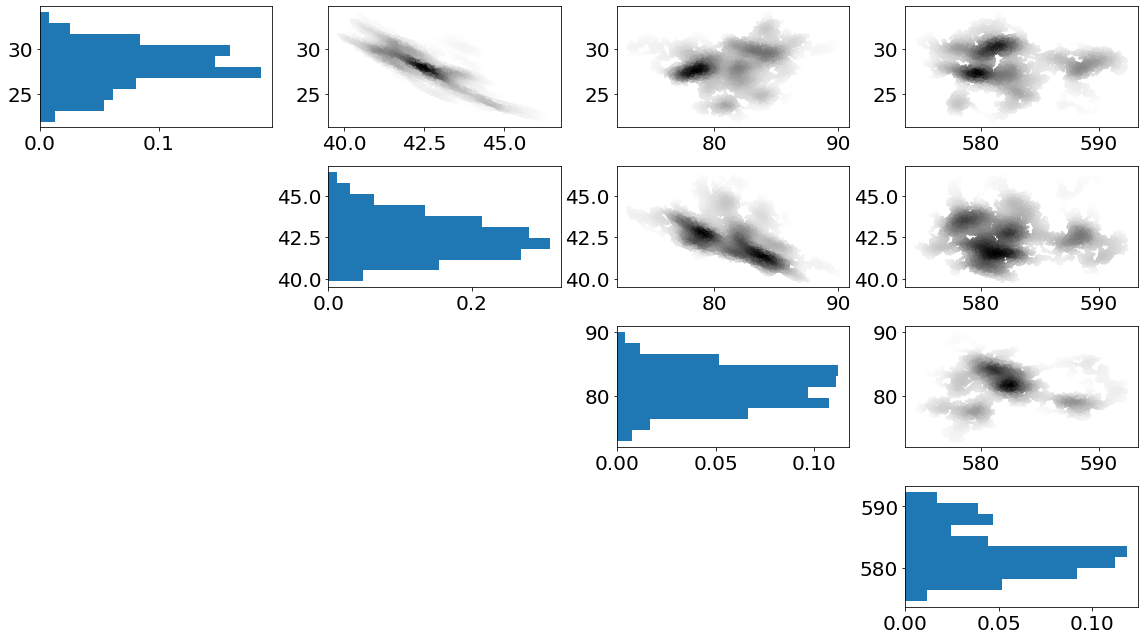

In [85]:
from scipy.stats import gaussian_kde



fig,ax=plt.subplots(4,4,figsize=(16,9))
fig.patch.set_facecolor('w')

plt.subplot(4,4,1)
plt.hist(x_list_subset[:,0],density=True, orientation='horizontal')
# plt.xlim([0.5,0])

plt.subplot(4,4,2)
xy = np.vstack([x_list_subset[:,0],x_list_subset[:,1]])
z = gaussian_kde(xy)(xy)
plt.scatter(x_list_subset[:,1],x_list_subset[:,0],c=z,cmap='Greys',s=5)

plt.subplot(4,4,3)
xy = np.vstack([x_list_subset[:,0],x_list_subset[:,2]])
z = gaussian_kde(xy)(xy)
plt.scatter(x_list_subset[:,2],x_list_subset[:,0],c=z,cmap='Greys',s=5)

plt.subplot(4,4,4)
xy = np.vstack([x_list_subset[:,0],x_list_subset[:,3]])
z = gaussian_kde(xy)(xy)
plt.scatter(x_list_subset[:,3],x_list_subset[:,0],c=z,cmap='Greys',s=5)




plt.subplot(4,4,6)
plt.hist(x_list_subset[:,1], density=True,orientation='horizontal')
# plt.xlim([100,0])

plt.subplot(4,4,7)
xy = np.vstack([x_list_subset[:,1],x_list_subset[:,2]])
z = gaussian_kde(xy)(xy)
plt.scatter(x_list_subset[:,2],x_list_subset[:,1],c=z,cmap='Greys',s=5)

plt.subplot(4,4,8)
xy = np.vstack([x_list_subset[:,1],x_list_subset[:,3]])
z = gaussian_kde(xy)(xy)
plt.scatter(x_list_subset[:,3],x_list_subset[:,1],c=z,cmap='Greys',s=5)




plt.subplot(4,4,11)
plt.hist(x_list_subset[:,2],density=True, orientation='horizontal')
# plt.xlim([100,0])

plt.subplot(4,4,12)
xy = np.vstack([x_list_subset[:,2],x_list_subset[:,3]])
z = gaussian_kde(xy)(xy)
plt.scatter(x_list_subset[:,3],x_list_subset[:,2],c=z,cmap='Greys',s=5)



plt.subplot(4,4,16)
plt.hist(x_list_subset[:,3],density=True, orientation='horizontal')
# plt.xlim([100,0])

for ind in (5,9,10,13,14,15):
    plt.subplot(4,4,ind)
    plt.axis('off')

plt.tight_layout()

In [87]:
import pickle
with open('100k_4param_MCMC.pickle', 'wb') as handle:
    pickle.dump(x_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Now do the same analysis but with variable layer thicknesses also

In [199]:
t0 = perf_counter()

step_size = 1.0e-4 # 0.1 m/s
step_size_h = 0.01e-3 # 0.01 m
# k_sensitivity = 0.000418 * len(kobs)
k_sensitivity = 5e-5
x0 = [0.038,0.043,0.080,0.60]
h0 = [0.1,0.005,0.010,0.020,0.0]
m0 = wrap_four_layer(x0,h0,kobs)
N = 200000

x_list = []
for i in tqdm(range(N)):
    x = x0 + step_size*(2*random_sample(len(x0))-1)
    h = h0 + step_size_h*(2*random_sample(len(h0))-1)
    h[-1]=0
    m = wrap_four_layer(x,h,kobs)
    L =  np.exp(-(m-m0)**2 / k_sensitivity**2)
    thr = random_sample()
    if L >= thr:
        x_list.append( np.hstack((h0,x0)) )
        x0 = x
        h0 = h
        m0 = m
x_list = np.array(x_list) * 1e3
print(f'Runtime was {perf_counter()-t0}')

# with open('100k_8param_MCMC.pickle', 'wb') as handle:
#     pickle.dump(x_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|█████████████████████████████████| 200000/200000 [2:43:20<00:00, 20.41it/s]

Runtime was 9800.663817997003


In [193]:
burnin_threshold = 0.33
print(f'Total accepted steps: {len(x_list)}')
print(f'Burn-in length: {round(len(x_list)*burnin_threshold)}')
x_list_subset=x_list[round(len(x_list)*burnin_threshold):-1,:]

Total accepted steps: 308
Burn-in length: 102


In [194]:
xy = np.vstack([x_list_subset[:,1],x_list_subset[:,5]])
z = gaussian_kde(xy)(xy)

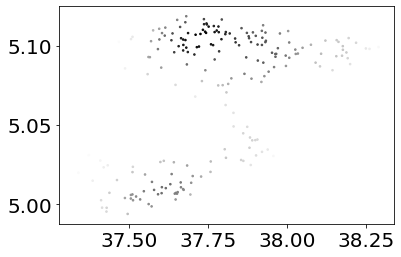

In [195]:
fig,ax=plt.subplots()
fig.patch.set_facecolor('w')
plt.scatter(x_list_subset[:,5],x_list_subset[:,1],c=z,s=2.5,cmap='Greys')

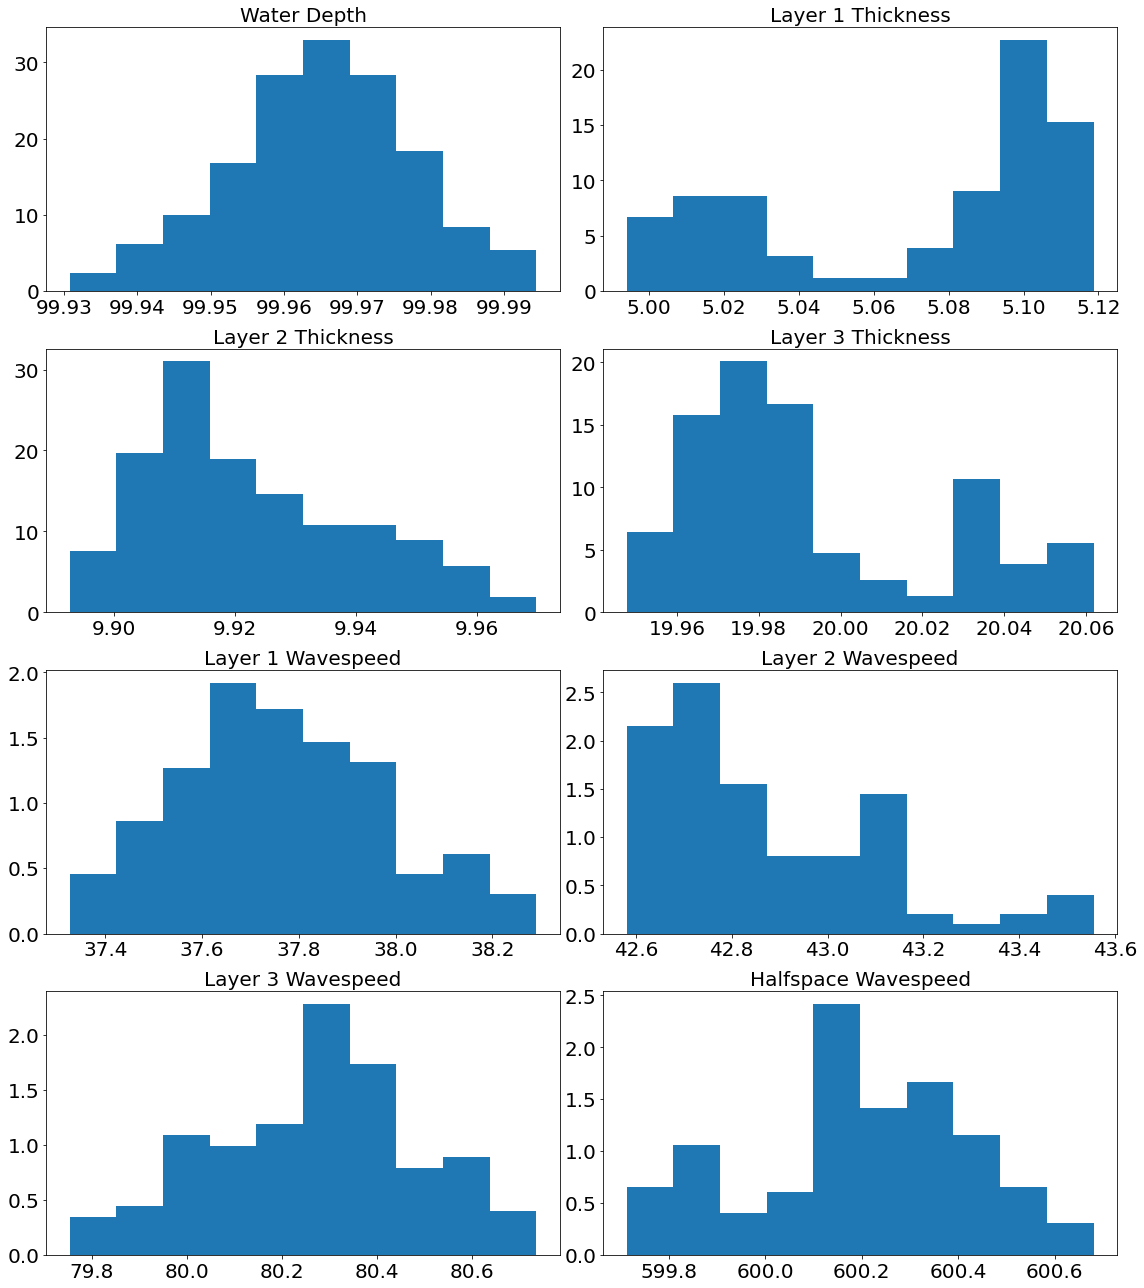

In [196]:
x_list_subset_noblank = np.delete(x_list_subset, 4, 1)
nvar = x_list_subset_noblank.shape[1]
fig,ax=plt.subplots(int(nvar/2),2,figsize=(16,18))
fig.patch.set_facecolor('w')
titles=['Water Depth',
       'Layer 1 Thickness',
       'Layer 2 Thickness',
       'Layer 3 Thickness',
       'Layer 1 Wavespeed',
       'Layer 2 Wavespeed',
       'Layer 3 Wavespeed',
       'Halfspace Wavespeed']

for i in range(nvar):
    
    ax=plt.subplot(int(nvar/2),2,i+1)
    ax.hist(x_list_subset_noblank[:,i],density=True)
    ax.title.set_text(titles[i])
    ax.title.set_fontsize(20)
plt.tight_layout()

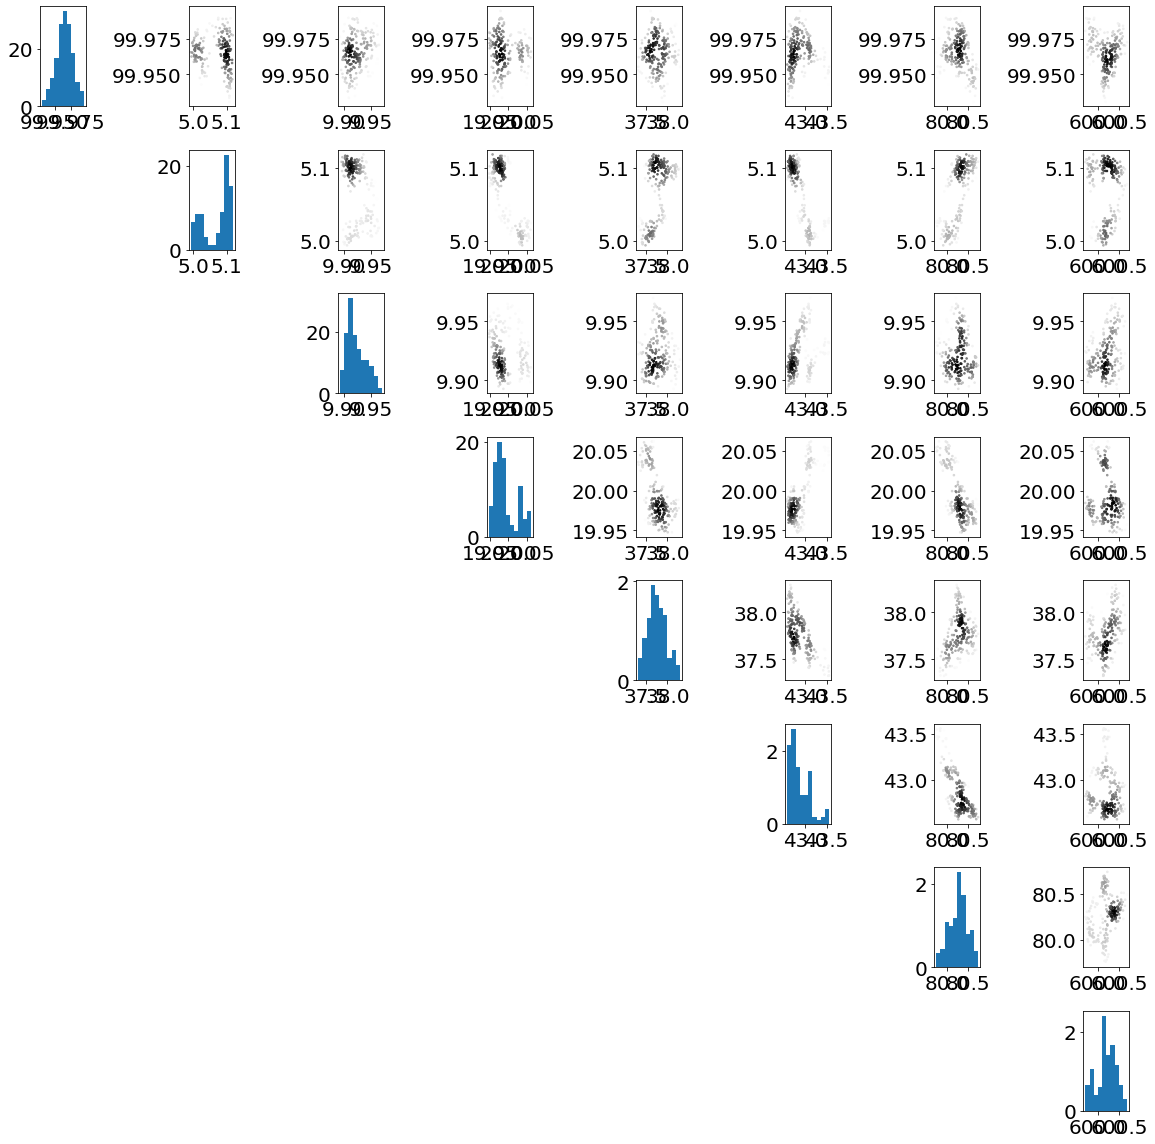

In [197]:
fig,ax=plt.subplots(nvar,nvar,figsize=(16,16))
fig.patch.set_facecolor('w')
ind=1
for j in range(nvar): # Column
    for i in range(nvar): # Row
        ax=plt.subplot(nvar,nvar,ind)
        if j > i:
            plt.axis('off')
        elif i==j:
            plt.hist(x_list_subset_noblank[:,i],density=True)
        else:
            xy = np.vstack([x_list_subset_noblank[:,i],x_list_subset_noblank[:,j]])
            z = gaussian_kde(xy)(xy)
            plt.scatter( x_list_subset_noblank[:,i] , 
                         x_list_subset_noblank[:,j] ,
                         s = 2.5,
                         c = z,
                         cmap = 'Greys')
        ind = ind+1
plt.tight_layout()

In [198]:
np.median(x_list_subset_noblank,axis=0).round()/1e3

array([0.1  , 0.005, 0.01 , 0.02 , 0.038, 0.043, 0.08 , 0.6  ])